In [1]:
import numpy as np
from numpy import pi as π
from numpy.linalg import eigvals, det, matrix_rank
from numpy.random import uniform
from scipy.integrate import odeint, cumtrapz

# Python control toolbox: https://python-control.readthedocs.io/
from control import place, ctrb, lqr, use_numpy_matrix
use_numpy_matrix(False)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams['font.size'] = 16

from IPython.display import HTML

In [2]:
# Inverted pendulum on a cart
ndims = 4

m = 1   # mass of pendulum
M = 5   # mass of cart
L = 2   # length of pendulum
g = -10 # acceleration due to gravity (approx)
d = 1   # cart damping

b = 1   # pendulum up (b=+1)

In [3]:
# RHS of ODE for full non-linear system

def pendcart(s, t, u, m=m, M=M, L=L, g=g, d=d):
    """
    Parameters
    ----------
    s : ndarray (4,)
        state x, v, θ, ω
    t : float
        time (ignored)
    u : function
        scalar u as fn of state s
    m : float
        pendulum bob mass
    M : float
        cart mass
    L : float
        pendulum length
    g : float
        gravitational acceleration (signed)
    d : float
        damping

    Returns
    -------
    ndarrray (4,) derivatives at point s
    """
    # Apply fn u to current state to get numerical value
    u = u(s)

    # Components of state vector
    x, v, θ, ω = s

    cosθ, sinθ = np.cos(θ), np.sin(θ)
    D = m * L**2 * (M + m*(1 - cosθ**2))
    
    dx = v
    dv = (-(m**2)*(L**2)*g*cosθ*sinθ + m*(L**2)*(m*L*(ω**2)*sinθ - d*v) + m*L**2*u) / D
    dθ = ω
    dω = ((m + M)*m*g*L*sinθ - m*L*cosθ*(m*L*(ω**2)*sinθ - d*v) - m*L*cosθ*u) / D

    return dx, dv, dθ, dω

In [4]:
# System matrices
A = np.array([
    [0,          1,                  0,  0],
    [0,       -d/M,            b*m*g/M,  0],
    [0,          0,                  0,  1],
    [0, -b*d/(M*L), -b*(m + M)*g/(M*L),  0]
])
B = np.array([[0, 1/M, 0, b/(M*L)]]).T

Controllability = ctrb(A, B)

print('System Matrix A:')
print(A)
print('Eigenvalues of A:', eigvals(A))
print('Controllability Matrix:')
print(Controllability)
print('Determinant of Controllability Matrix:', det(Controllability))
print('Rank of Controllability Matrix:', matrix_rank(Controllability))

System Matrix A:
[[ 0.   1.   0.   0. ]
 [ 0.  -0.2 -2.   0. ]
 [ 0.   0.   0.   1. ]
 [ 0.  -0.1  6.   0. ]]
Eigenvalues of A: [ 0.         -2.431123   -0.23363938  2.46476238]
Controllability Matrix:
[[ 0.      0.2    -0.04   -0.192 ]
 [ 0.2    -0.04   -0.192   0.0784]
 [ 0.      0.1    -0.02    0.604 ]
 [ 0.1    -0.02    0.604  -0.1008]]
Determinant of Controllability Matrix: 0.0196
Rank of Controllability Matrix: 4


In [5]:
# Design LQR Controller
Q, R = np.identity(ndims), 1e-4
(K_r,), *_ = lqr(A, B, Q, R)

In [6]:
# Simulate closed-loop system
tspan = np.arange(0, 10, 0.001)
ntimes = len(tspan)

# Initial condition (just off vertical)
x_0 = [-1, 0, π+0.1, 0]

# Desired reference position (vertical and 2 units to the right of initial condition)
w_r = np.array([1, 0, π, 0])

# Control law
u = lambda x, K=K_r, w_r=w_r: -K @ (x - w_r)

# Simulation
x_traj_lsq = odeint(pendcart, x_0, tspan, args=(u,))

# Cost function
jz_lqr = cumtrapz(
    [(x - w_r) @ Q @ (x - w_r) + u(x)**2 * R for x in x_traj_lsq],
    initial=0
)

In [7]:
# Animation of Figure 18.12

class CartWithPendulum:
    def __init__(self, ax, h=0.5*np.sqrt(M/5), w=np.sqrt(M/5), l=L, r=0.3*np.sqrt(m/5), x=0, θ=π):
        self.h, self.w, self.l = h, w, l

        # cart (centre of cart and pivot will be at height 0)
        self.cart = ax.add_patch(Rectangle((0, 0), w, h, color='slateblue', joinstyle='round'))
        
        # wheels
        wheel_radius = w/10
        axle_radius = w/50
        self.left_wheel = [
            ax.add_patch(Circle((0, 0), wheel_radius, facecolor='white', edgecolor='black')),
            ax.add_patch(Circle((0, 0), axle_radius, color='black'))
        ]
        self.right_wheel = [
            ax.add_patch(Circle((0, 0), wheel_radius, facecolor='white', edgecolor='black')),
            ax.add_patch(Circle((0, 0), axle_radius, color='black'))
        ]
        
        # pendulum
        self.pivot = ax.add_patch(Circle((0, 0), axle_radius, color='black'))
        self.rod, = ax.plot((0, 1), (0, 1), color='black')
        self.bob = ax.add_patch(Circle((0, 0), r, facecolor='crimson', edgecolor='black', zorder=10))

        # (fixed) ground
        ax.axhspan(-0.5, -h/2 - wheel_radius, hatch='/', fill=False)
        ax.axhline(-h/2 - wheel_radius, color='black')

        self.move_to(x, θ)


    def move_to(self, x, θ):
        # Bob position (pivot is at (x, 0))
        c_x, c_y = x + self.l * np.sin(θ), -self.l * np.cos(θ)

        self.cart.set_xy((-self.w/2 + x, -self.h/2))

        for circle in self.left_wheel:
            circle.set_center((x - 0.35*self.w, -self.h/2))
        for circle in self.right_wheel:
            circle.set_center((x + 0.35*self.w, -self.h/2))

        self.pivot.set_center((x, 0))
        self.rod.set_data((x, c_x), (0, c_y))
        self.bob.set_center((c_x, c_y))

# Thin out data for animation
stride = 100
x_traj_plot = x_traj_lsq[::stride]
nframes = len(x_traj_plot)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect(1)
ax.set_xlabel('x')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-0.5, 2.25)

cart = CartWithPendulum(ax)

def animate(t, cart=cart, trajectory=x_traj_plot):
    x, _, θ, _ = trajectory[t]
    cart.move_to(x, θ)

animation = FuncAnimation(fig, animate, frames=nframes, interval=50, repeat=False)
plt.close(fig)
HTML(animation.to_jshtml())

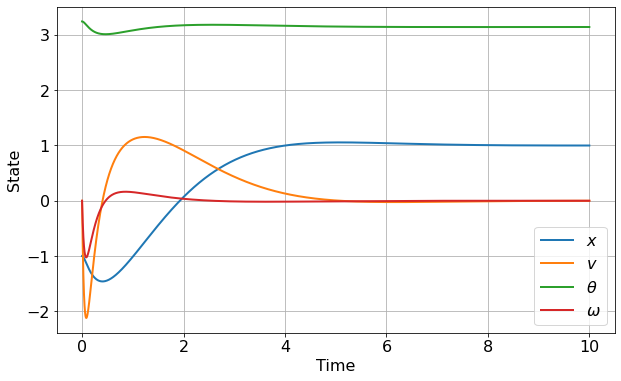

In [8]:
# Figure 8.13
fig, ax = plt.subplots(figsize=(10, 6))
labels = ['$x$', '$v$', r'$\theta$', r'$\omega$']
for x, label in zip(x_traj_lsq.T, labels):
    ax.plot(tspan, x, linewidth=2, label=label)

ax.set_xlabel('Time')
ax.set_ylabel('State')
ax.legend()
ax.grid(True);

In [9]:
# Compare with many examples of alternative pole placement
ntrials = 100

# Control input functions for each random pole placement
Ks = [
    place(A, B, pole)[0]
    for pole in uniform(-3.5, -0.5, size=(ntrials, ndims))
]
us = [lambda x, K=K, w_r=w_r: -K @ (x - w_r) for K in Ks]

# Simulations for each control input fn
x_trajs = np.array([odeint(pendcart, x_0, tspan, args=(u,)) for u in us])

# Cumulative cost functions for each control input fn and its trajectory
jzs = cumtrapz(
    [[(x - w_r) @ Q @ (x - w_r) + u(x)**2 * R for x in x_traj] for u, x_traj in zip(us, x_trajs)],
    axis=1, initial=0
)

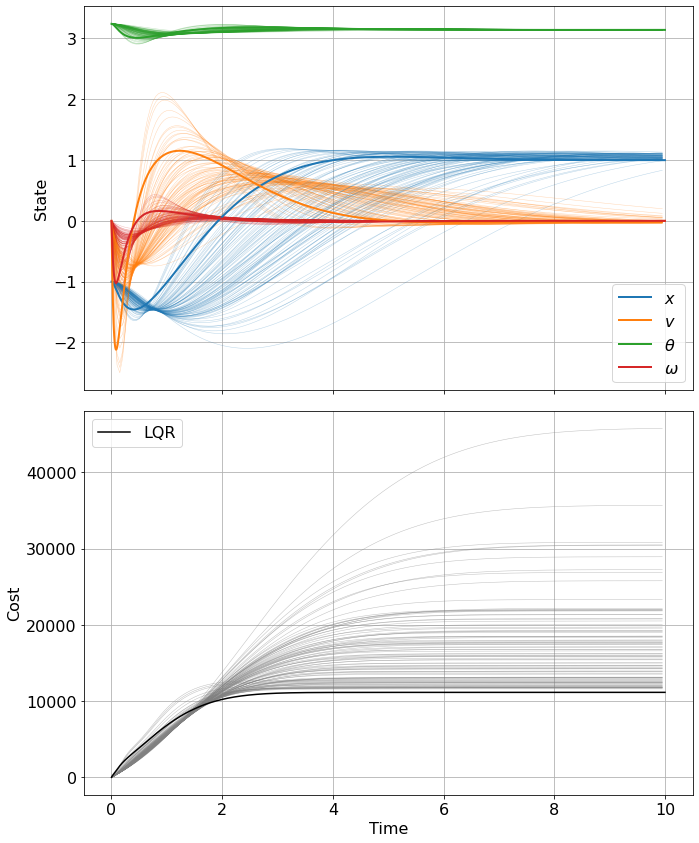

In [10]:
# Figure 18.14

# Thin out multiple plots for efficiency
stride = 50
ts_plot = tspan[::stride]
x_trajs_plot = x_trajs[:, ::stride, :]
jzs_plot = jzs[:, ::stride]

labels = ['$x$', '$v$', r'$\theta$', r'$\omega$']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 12))

for x_traj_plot in x_trajs_plot:
    axs[0].plot(ts_plot, x_traj_plot, linewidth=0.5, alpha=0.3)
    axs[0].set_prop_cycle(None)
for xj, label in zip(x_traj_lsq.T, labels):
    axs[0].plot(tspan, xj, linewidth=2, label=label)

axs[0].set_ylabel('State')
axs[0].grid(True)
axs[0].legend()

for jz in jzs_plot:
    axs[1].plot(ts_plot, jz, color='grey', linewidth=0.5, alpha=0.5)
axs[1].plot(tspan, jz_lqr, color='black', label='LQR')

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cost')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()